In [2]:
!pip3 install -q -U matplotlib seaborn

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 시각화 설정
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12

# Warning 메시지 무시
import warnings
warnings.filterwarnings("ignore")

In [7]:
# 2. 데이터 로드

# 데이터 경로 설정
base_path = os.path.dirname(os.getcwd())

original_data_path = os.path.join(base_path, "bay", "data", "data.npy")
masked_data_path = os.path.join(base_path, "bay", "masked", "block_fault0.0015_noise0.0500", "data.npy")
mask_path = os.path.join(base_path, "bay", "masked", "block_fault0.0015_noise0.0500", "mask.npy")

# 경로 존재 여부 확인
if not os.path.exists(original_data_path):
    print(f"원본 데이터 파일이 존재하지 않습니다: {original_data_path}")
    print("STGAN/bay/data/ 폴더 경로를 확인해주세요.")

if not os.path.exists(masked_data_path) or not os.path.exists(mask_path):
    print(f"마스킹된 데이터 파일이 존재하지 않습니다.")
    print("먼저 create_missing_data.py 스크립트를 실행하여 결측치 데이터를 생성해주세요.")
    print("예시: python ./STGAN/data_pipeline/create_missing_data.py")

# 데이터 로드
try:
    original_data = np.load(original_data_path)
    masked_data = np.load(masked_data_path)
    mask = np.load(mask_path)

    print(f"원본 데이터 형태: {original_data.shape}")
    print(f"마스킹된 데이터 형태: {masked_data.shape}")
    print(f"마스크 형태: {mask.shape}")

    # 결측치 비율 계산
    missing_ratio = 1.0 - np.mean(mask)
    print(f"\n결측치 비율: {missing_ratio:.4f} ({missing_ratio*100:.2f}%)")
except Exception as e:
    print(f"데이터 로드 중 오류 발생: {str(e)}")

원본 데이터 형태: (36288, 365, 6, 2)
마스킹된 데이터 형태: (36288, 365, 6, 2)
마스크 형태: (36288, 365, 6, 2)

결측치 비율: 0.0578 (5.78%)


In [14]:
# 3. 단일 시계열 데이터 시각화 함수 정의


def visualize_missing_data(original_data, masked_data, node_idx=0, feature_idx=0, time_range=100):
    """
    원본 데이터와 마스킹된 데이터를 시각화하여 비교합니다

    Args:
        original_data: 원본 데이터
        masked_data: 마스킹된 데이터
        node_idx: 시각화할 노드 인덱스
        feature_idx: 시각화할 특성 인덱스 (0 또는 1)
        time_range: 시각화할 시간 범위
    """
    plt.figure(figsize=(14, 6))

    # 시각화할 데이터 선택
    original_slice = original_data[:time_range, node_idx, feature_idx, 0]
    masked_slice = masked_data[:time_range, node_idx, feature_idx, 0]

    # 원본 데이터 플롯
    plt.plot(original_slice, "b-", linewidth=2, label="original data")

    # 결측치가 있는 데이터 플롯
    plt.plot(masked_slice, "r-", alpha=0.7, label="masked data")

    # 결측치 하이라이트
    missing_indices = np.where(np.isnan(masked_slice))[0]
    if len(missing_indices) > 0:
        original_values = original_slice[missing_indices]
        plt.scatter(missing_indices, original_values, c="red", marker="x", s=100, label="missing data location")

    plt.title(f"node {node_idx}, feature {feature_idx} of original data and masked data")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # 추가 정보 출력
    missing_count = np.sum(np.isnan(masked_slice))
    print(f"\n선택된 시계열 데이터 분석:")
    print(f"- 총 데이터 포인트: {len(original_slice)}개")
    print(f"- 결측치 개수: {missing_count}개 ({missing_count/len(original_slice)*100:.2f}%)")

    return original_slice, masked_slice


선택된 시계열 데이터 분석:
- 총 데이터 포인트: 100개
- 결측치 개수: 5개 (5.00%)


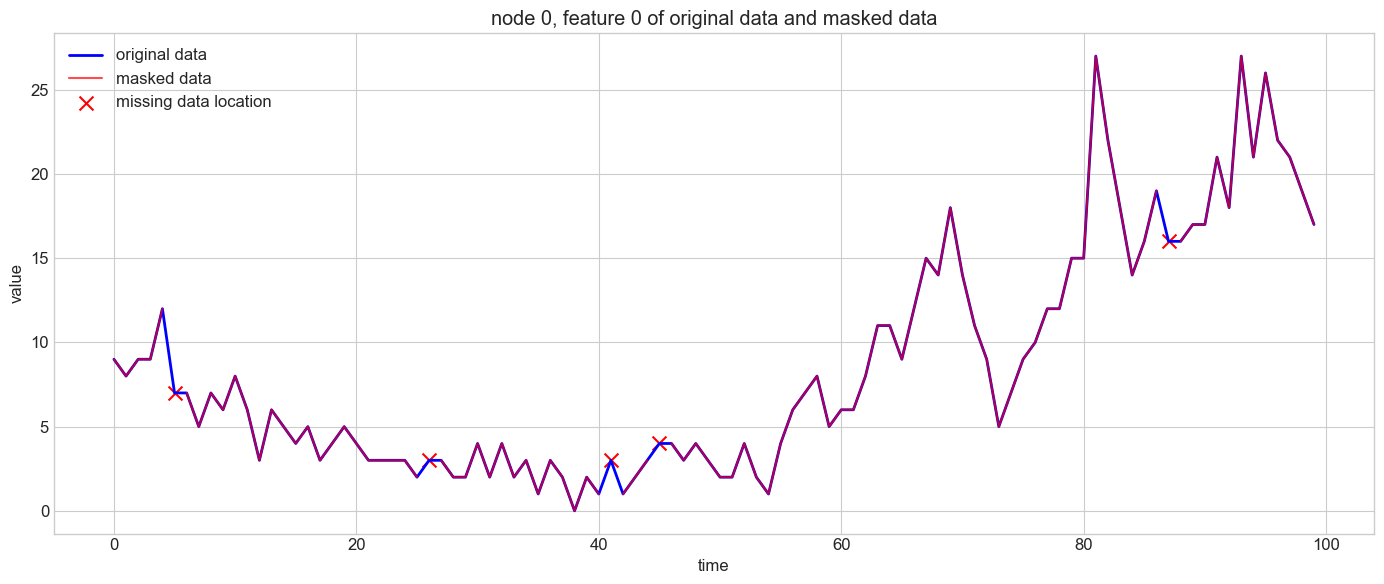

In [15]:
# 단일 시계열 데이터 시각화
node_idx = 0  # 노드 인덱스 (0부터 시작)
feature_idx = 0  # 특성 인덱스 (0 또는 1)
time_range = 100  # 시각화할 시간 범위

original_slice, masked_slice = visualize_missing_data(original_data, masked_data, node_idx, feature_idx, time_range)

In [16]:
# 5. 데이터 테이블로 확인하기

# 처음 20개 데이터 포인트 비교
comparison_df = pd.DataFrame(
    {
        "시간": range(min(20, len(original_slice))),
        "원본 데이터": original_slice[:20],
        "마스킹된 데이터": masked_slice[:20],
    }
)

# 결측 여부 열 추가
comparison_df["결측 여부"] = comparison_df["마스킹된 데이터"].isna().map({True: "결측", False: "유지"})

print("\n원본 데이터와 마스킹된 데이터 비교 (처음 20개 포인트):")
print(comparison_df)


원본 데이터와 마스킹된 데이터 비교 (처음 20개 포인트):
    시간  원본 데이터  마스킹된 데이터 결측 여부
0    0     9.0       9.0    유지
1    1     8.0       8.0    유지
2    2     9.0       9.0    유지
3    3     9.0       9.0    유지
4    4    12.0      12.0    유지
5    5     7.0       NaN    결측
6    6     7.0       7.0    유지
7    7     5.0       5.0    유지
8    8     7.0       7.0    유지
9    9     6.0       6.0    유지
10  10     8.0       8.0    유지
11  11     6.0       6.0    유지
12  12     3.0       3.0    유지
13  13     6.0       6.0    유지
14  14     5.0       5.0    유지
15  15     4.0       4.0    유지
16  16     5.0       5.0    유지
17  17     3.0       3.0    유지
18  18     4.0       4.0    유지
19  19     5.0       5.0    유지


In [19]:
# 6. 여러 노드 시각화 함수 정의

def visualize_multiple_nodes(original_data, masked_data, node_indices=[0, 1, 2, 3], feature_idx=0, time_range=100):
    """
    여러 노드의 원본 데이터와 마스킹된 데이터를 시각화하여 비교합니다
    """
    n_nodes = len(node_indices)
    fig, axes = plt.subplots(n_nodes, 1, figsize=(14, 4 * n_nodes))

    if n_nodes == 1:
        axes = [axes]

    for i, node_idx in enumerate(node_indices):
        # 시각화할 데이터 선택
        original_slice = original_data[:time_range, node_idx, feature_idx, 0]
        masked_slice = masked_data[:time_range, node_idx, feature_idx, 0]

        # 원본 데이터 플롯
        axes[i].plot(original_slice, "b-", linewidth=2, label="original data")

        # 결측치가 있는 데이터 플롯
        axes[i].plot(masked_slice, "r-", alpha=0.7, label="masked data")

        # 결측치 하이라이트
        missing_indices = np.where(np.isnan(masked_slice))[0]
        if len(missing_indices) > 0:
            original_values = original_slice[missing_indices]
            axes[i].scatter(missing_indices, original_values, c="red", marker="x", s=100, label="missing data location")

        axes[i].set_title(f"node {node_idx}, feature {feature_idx}")
        axes[i].set_xlabel("time")
        axes[i].set_ylabel("value")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    fig.suptitle("comparison of missing data pattern in multiple nodes", fontsize=16, y=1.02)
    plt.subplots_adjust(top=0.95)

    return fig

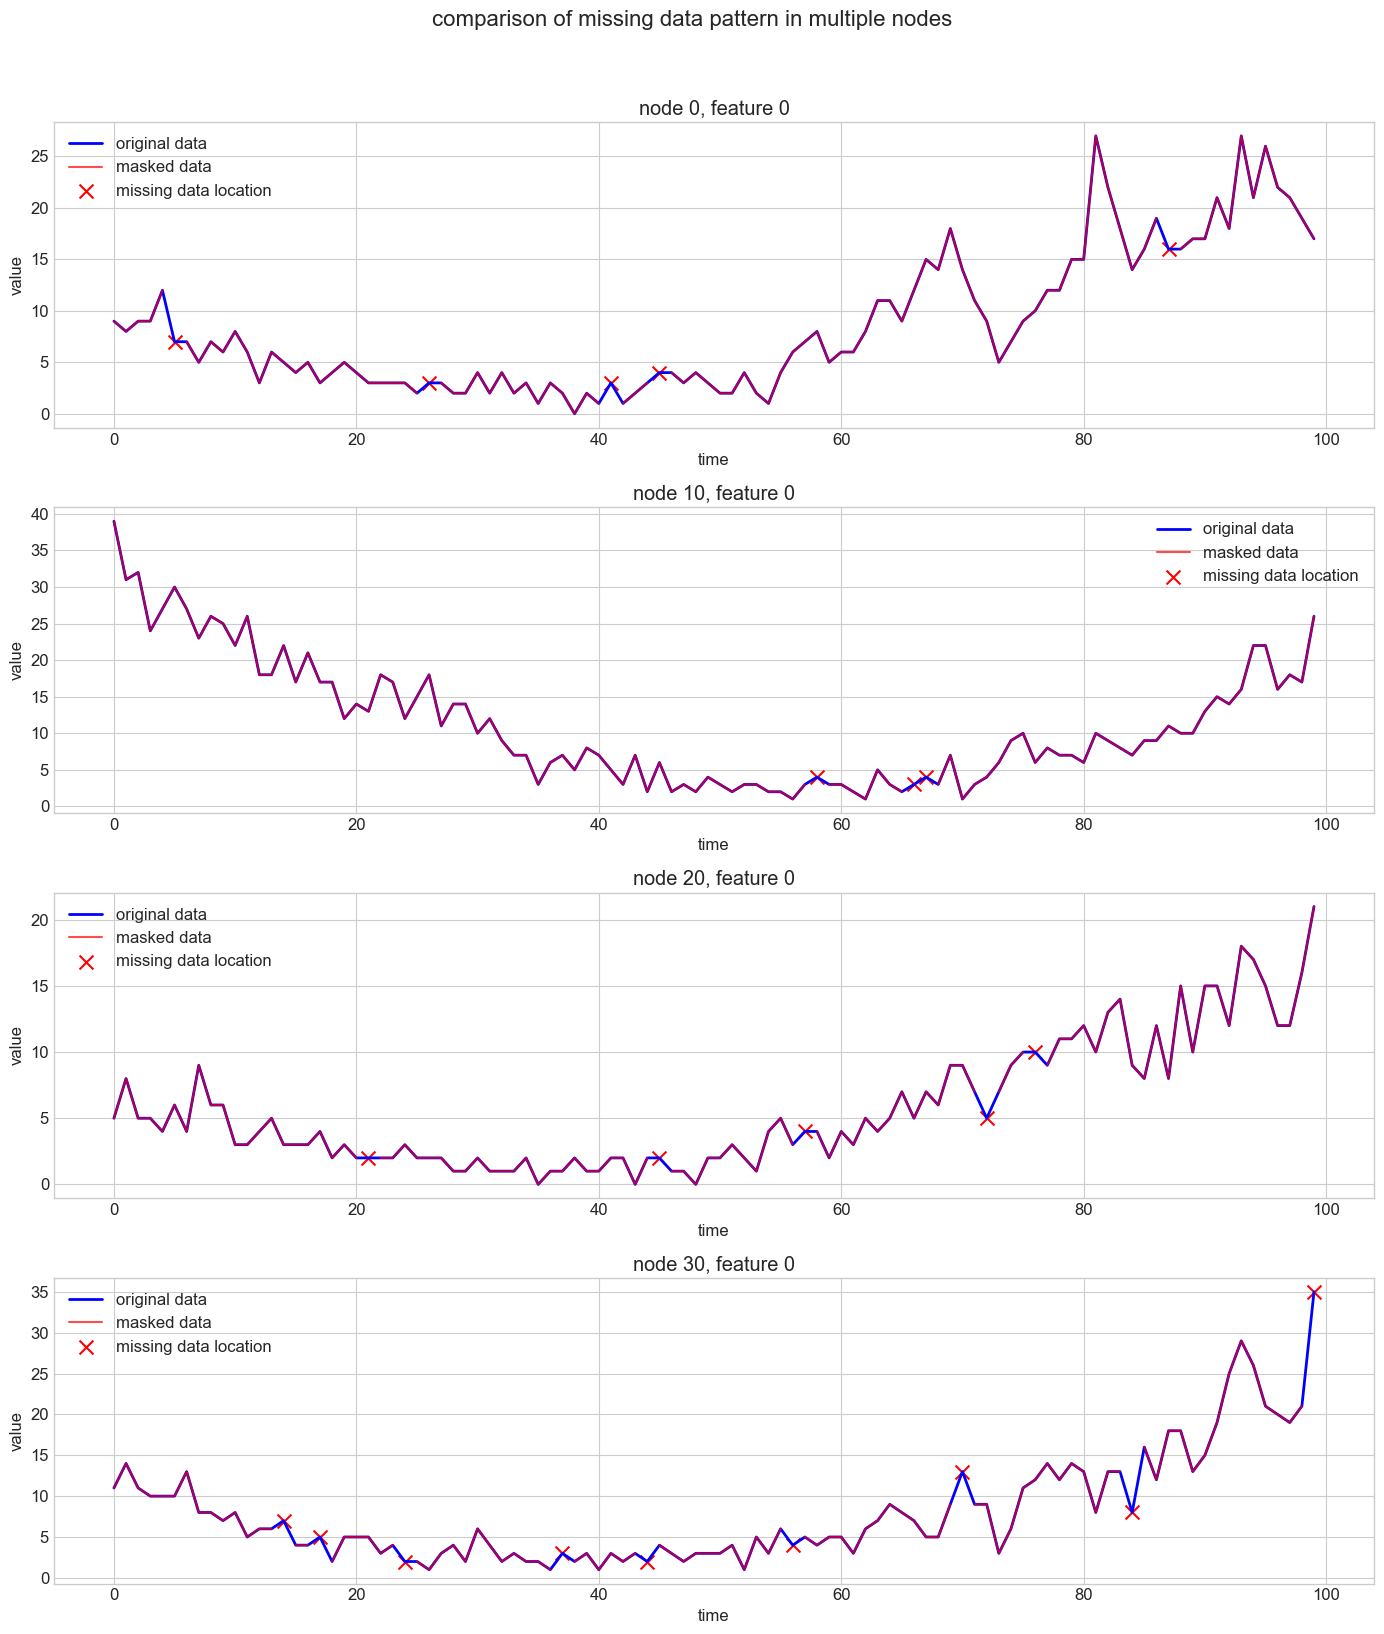

In [20]:
# 여러 노드 시각화
fig = visualize_multiple_nodes(original_data, masked_data, node_indices=[0, 10, 20, 30], feature_idx=0, time_range=100)
plt.show()

In [21]:
# 8. 결측치 분포 분석 함수 정의

def analyze_missing_pattern(mask, feature_idx=0):
    """
    결측치 분포를 분석합니다
    """
    # 노드별 결측치 비율
    num_times, num_nodes = mask.shape[:2]

    node_missing_ratios = []
    for node in range(num_nodes):
        node_mask = mask[:, node, feature_idx, 0]
        missing_ratio = 1.0 - np.mean(node_mask)
        node_missing_ratios.append(missing_ratio)

    # 시간별 결측치 비율
    time_missing_ratios = []
    for t in range(num_times):
        time_mask = mask[t, :, feature_idx, 0]
        missing_ratio = 1.0 - np.mean(time_mask)
        time_missing_ratios.append(missing_ratio)

    return np.array(node_missing_ratios), np.array(time_missing_ratios)

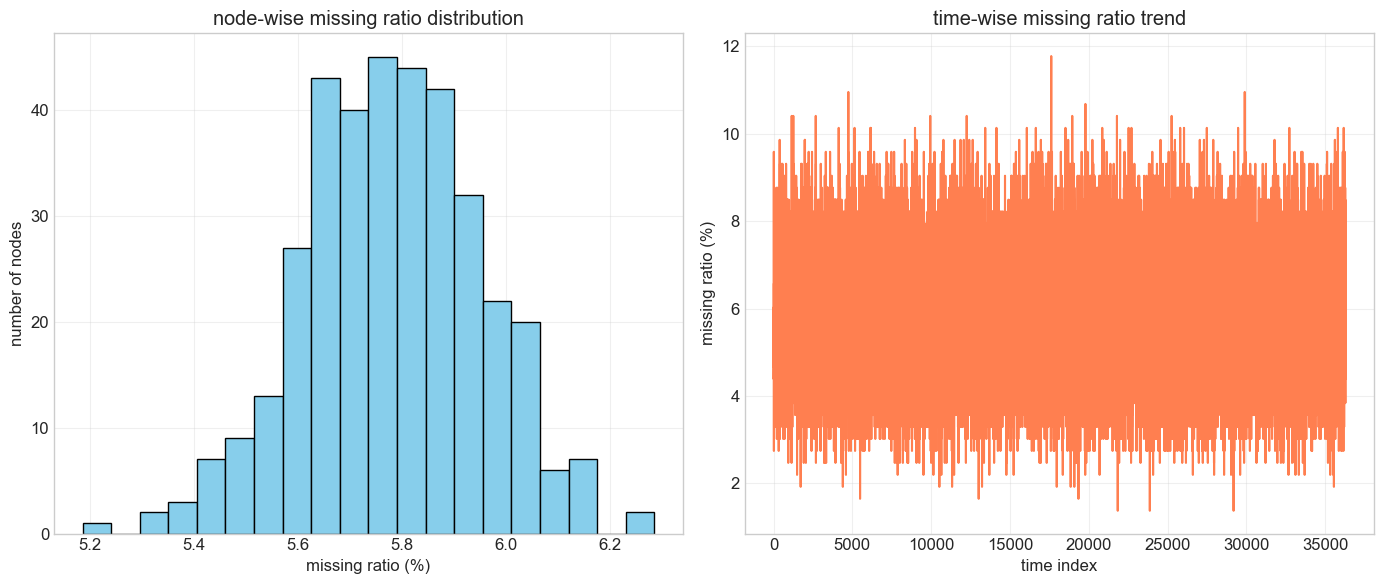

In [22]:
# 결측치 분포 분석
node_missing_ratios, time_missing_ratios = analyze_missing_pattern(mask)

# 노드별 결측치 비율 히스토그램
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(node_missing_ratios * 100, bins=20, color="skyblue", edgecolor="black")
plt.title("node-wise missing ratio distribution")
plt.xlabel("missing ratio (%)")
plt.ylabel("number of nodes")
plt.grid(True, alpha=0.3)

# 시간별 결측치 비율 그래프
plt.subplot(1, 2, 2)
plt.plot(time_missing_ratios * 100, color="coral")
plt.title("time-wise missing ratio trend")
plt.xlabel("time index")
plt.ylabel("missing ratio (%)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# 10. 결측치 히트맵 함수 정의
def plot_missing_heatmap(mask, feature_idx=0, time_start=0, time_end=100, node_start=0, node_end=20):
    """
    결측치 패턴을 2D 히트맵으로 시각화합니다
    """
    # 마스크에서 일부분 선택 (1: 유효한 데이터, 0: 결측치)
    selected_mask = mask[time_start:time_end, node_start:node_end, feature_idx, 0]

    # 시각화를 위해 반전 (1: 결측치, 0: 유효한 데이터)
    missing_pattern = 1 - selected_mask

    plt.figure(figsize=(12, 8))
    sns.heatmap(missing_pattern.T, cmap="Reds", cbar_kws={"label": "missing or not"})
    plt.title(f"missing data pattern heatmap (feature {feature_idx})")
    plt.xlabel("time")
    plt.ylabel("node ID")
    plt.yticks(np.arange(len(range(node_start, node_end))) + 0.5, labels=range(node_start, node_end))
    plt.xticks(np.arange(0, time_end - time_start, 10) + 0.5, labels=range(time_start, time_end, 10))
    plt.tight_layout()

    return plt.gcf()

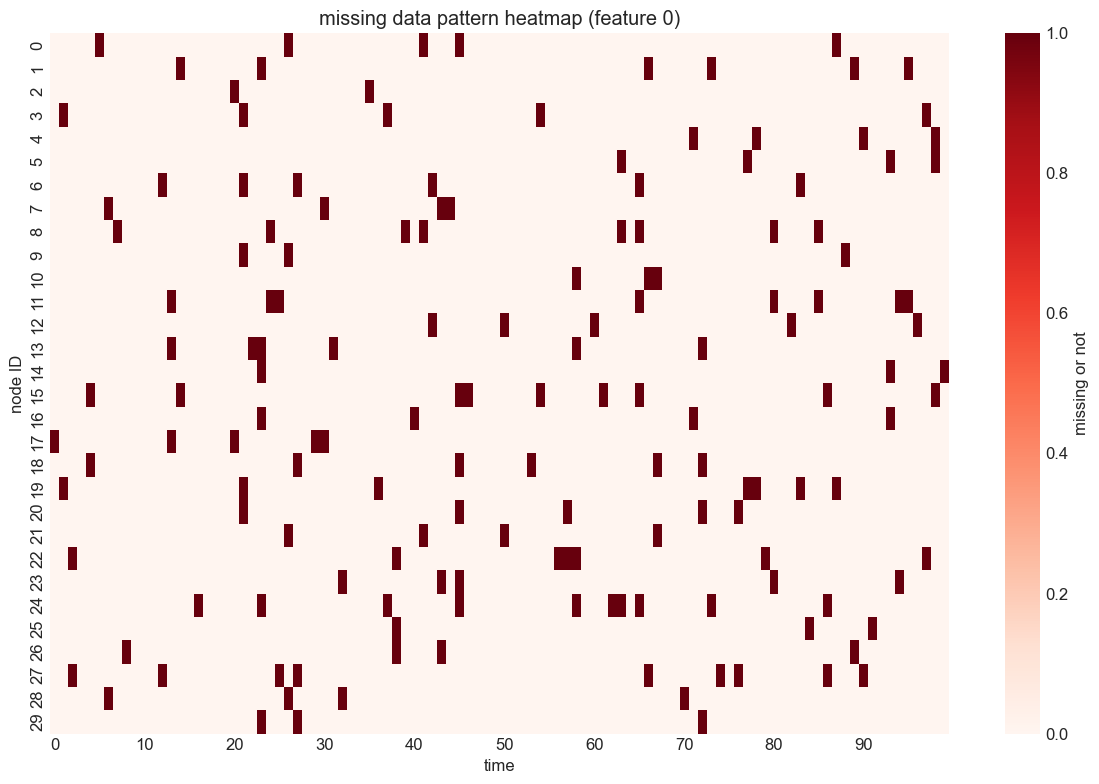

In [24]:
fig = plot_missing_heatmap(mask, feature_idx=0, time_start=0, time_end=100, node_start=0, node_end=30)
plt.show()


선택된 시계열 데이터 분석:
- 총 데이터 포인트: 150개
- 결측치 개수: 6개 (4.00%)


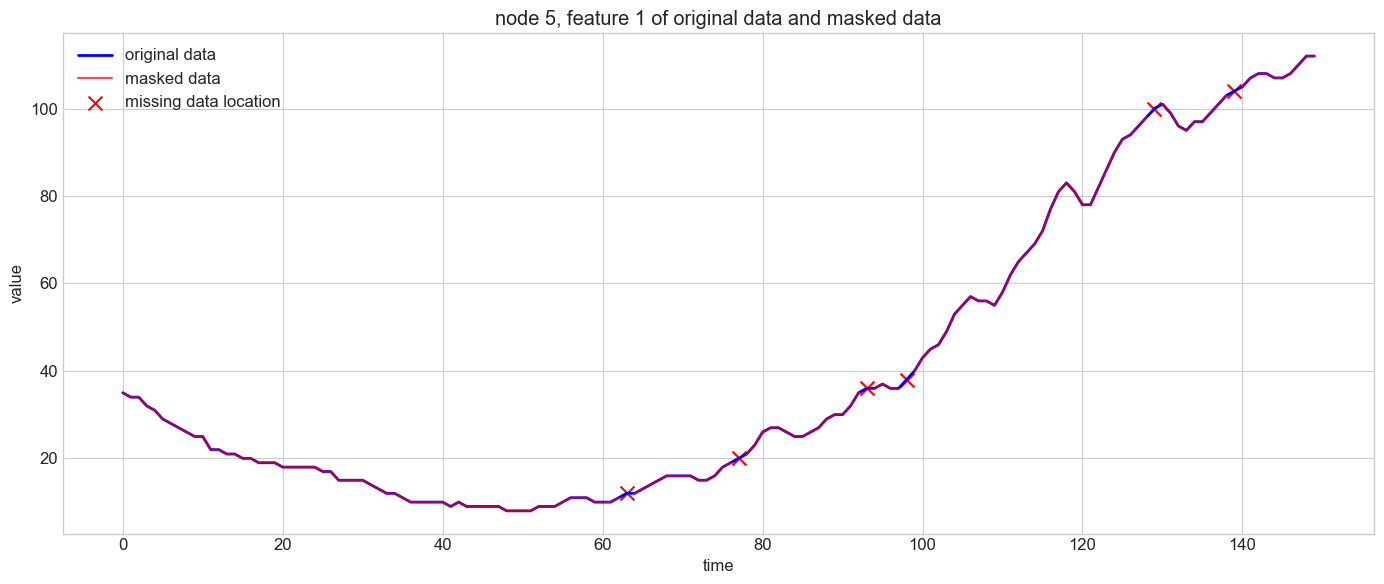

In [25]:
# 사용자 정의 시각화
node_idx = 5  # 원하는 노드 인덱스 입력
feature_idx = 1  # 원하는 특성 인덱스 입력 (0 또는 1)
time_range = 150  # 원하는 시간 범위 입력

# 시각화 실행
original_slice, masked_slice = visualize_missing_data(original_data, masked_data, node_idx, feature_idx, time_range)

In [26]:
# 13. 연속 결측 구간 분석 함수 정의

def analyze_consecutive_missing(masked_data, node_idx=0, feature_idx=0):
    """
    연속적인 결측치 구간을 분석합니다.
    """
    # 한 노드의 시계열 데이터 추출
    time_series = masked_data[:, node_idx, feature_idx, 0]

    # 결측치 여부 마스크 (True: 결측치)
    is_missing = np.isnan(time_series)

    # 연속된 결측 구간 찾기
    consecutive_lengths = []
    current_length = 0

    for i in range(len(is_missing)):
        if is_missing[i]:
            current_length += 1
        elif current_length > 0:
            consecutive_lengths.append(current_length)
            current_length = 0

    # 마지막 구간 처리
    if current_length > 0:
        consecutive_lengths.append(current_length)

    return consecutive_lengths

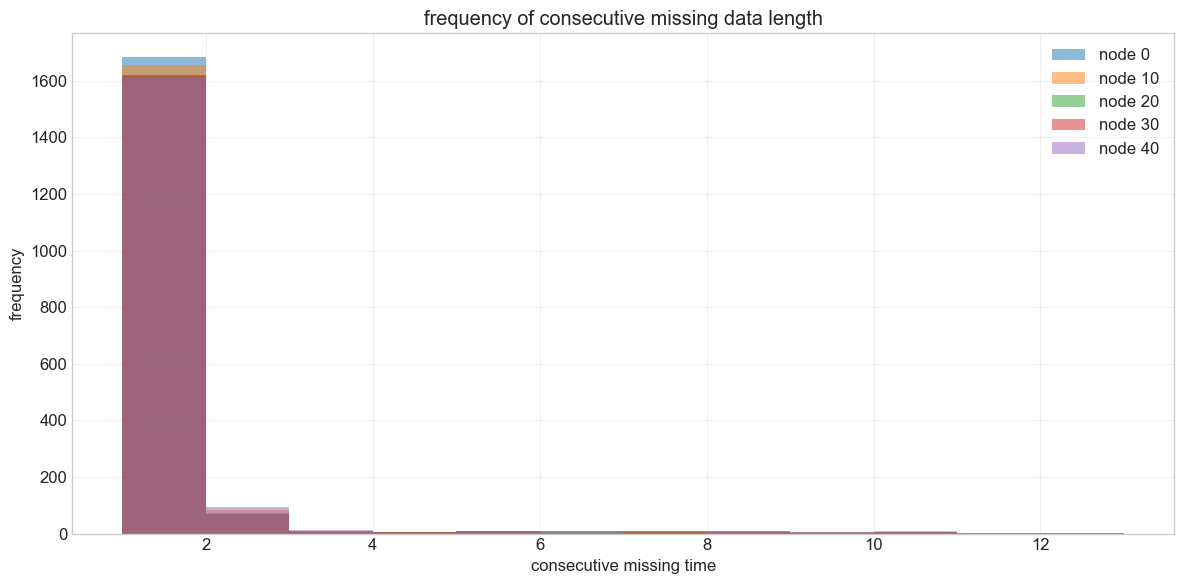

In [27]:
# 여러 노드에 대한 연속 결측 구간 분석
nodes_to_analyze = [0, 10, 20, 30, 40]
feature_to_analyze = 0

plt.figure(figsize=(12, 6))

for node_idx in nodes_to_analyze:
    consecutive_lengths = analyze_consecutive_missing(masked_data, node_idx, feature_to_analyze)
    if consecutive_lengths:
        plt.hist(consecutive_lengths, bins=range(1, max(consecutive_lengths) + 2), alpha=0.5, label=f"node {node_idx}")
    else:
        print(f"node {node_idx} has no missing data.")

plt.title("frequency of consecutive missing data length")
plt.xlabel("consecutive missing time")
plt.ylabel("frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
def main():
    """
    모든 시각화를 저장하고 싶을 때 사용
    """
    print("STGAN 결측치 데이터 시각화를 시작합니다...")

    # 모든 그래프를 저장할지 여부
    save_figures = True
    output_dir = "./STGAN/visualizations/"

    if save_figures:
        os.makedirs(output_dir, exist_ok=True)

        # 단일 시계열 시각화 저장
        plt.figure()
        original_slice, masked_slice = visualize_missing_data(
            original_data, masked_data, node_idx=0, feature_idx=0, time_range=100
        )
        plt.savefig(os.path.join(output_dir, "single_timeseries.png"), dpi=300)

        # 여러 노드 시각화 저장
        fig = visualize_multiple_nodes(
            original_data, masked_data, node_indices=[0, 10, 20, 30], feature_idx=0, time_range=100
        )
        fig.savefig(os.path.join(output_dir, "multiple_nodes.png"), dpi=300)

        # 결측치 분포 분석 저장
        plt.figure(figsize=(14, 6))
        node_missing_ratios, time_missing_ratios = analyze_missing_pattern(mask)

        plt.subplot(1, 2, 1)
        plt.hist(node_missing_ratios * 100, bins=20, color="skyblue", edgecolor="black")
        plt.title("노드별 결측치 비율 분포")
        plt.xlabel("결측치 비율 (%)")
        plt.ylabel("노드 수")

        plt.subplot(1, 2, 2)
        plt.plot(time_missing_ratios * 100, color="coral")
        plt.title("시간별 결측치 비율 추이")
        plt.xlabel("시간 인덱스")
        plt.ylabel("결측치 비율 (%)")

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, "missing_distribution.png"), dpi=300)

        # 결측치 히트맵 저장
        fig = plot_missing_heatmap(mask, feature_idx=0, time_start=0, time_end=100, node_start=0, node_end=30)
        fig.savefig(os.path.join(output_dir, "missing_heatmap.png"), dpi=300)

        print(f"모든 시각화가 {output_dir} 디렉토리에 저장되었습니다.")

    print("결측치 데이터 시각화가 완료되었습니다.")